# Shape classification
## Author: Angel Lopez Manriquez
### Objectives
Classify the countour of an image appropiately.

### What we will be discused
Preprocess the data, assign each instance apropriately from the 4 dataset given. Dimensionality reduction with hu moments and measuring the performance of some classifiers

In [309]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import cv2  # computer vision library

import os  # path.join, listdir
import random  
import functools  # partial. Functional programming utilities
from tqdm import tqdm  # Very cool progress bar :D


from scipy.io import loadmat  # it loads .mat files
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from IPython.display import display, HTML, Markdown  # exclusive for jupyter notebook

from collections import Counter
from typing import List, Tuple  # Explicit type, better explanation of the arguments without comments



In [296]:
plt.style.use('seaborn')

def display_markdown(text):
    display(Markdown(text))

### What is the dasaset about ?
There are four dataset attached. Each dataset contains labeled data. Each instance provies an array of ordered pairs $\{(x_i, y_i)\}$ that describes the contour of a shape, the length of each array doesn't share the same length, however the number of samples per each class is the same. The basename of each .mat file describes appropiately each instance, the syntax is ClassN_SampleM.mat. We use the naming convention to load all .mat files. 

In [297]:

def plot_mat(x_i, y_i):
    '''Plot the countour of the image given its coordinates.'''
    u, v = col_j(x_i, 0), col_j(x_i, 1)
    display(y_i)
    plt.scatter(u, v, s=2)
    plt.show()
    
def get_processed_data(i: int):  
    '''Since there're 4 subdirectories, 0 <= i <= 3. '''
    root_dir = 'hmm_gpd'
    class_subdirs = [os.path.join(root_dir, subdir) for subdir in os.listdir(root_dir)]
    selected_ds_path = class_subdirs[i]
    basenames = os.listdir(selected_ds_path)
    basenames.sort()   # for better visualization, not required
    X = [loadmat(os.path.join(selected_ds_path, bname))['x'] for bname in basenames]
    y = [int(bname[5]) for bname in basenames]
    
    # you'd better return a np.array. it provides a faster performance than a list of ints
    return np.array(X), np.array(y)  

## Preprocessing
The main problem to deal with is the dimensionality, we need to reduce the dimensionality somehow without lossing much information as posible. To do so, we define an image momentum as

$$ M_{ij} = \sum_x \sum_y x^i y^j I(x, y) $$

Where $I(x, y)$ is the value associated at pixel with coordinates $(x, y)$, in this dataset, $I(x, y): \rightarrow \{0, 1\}$

In [298]:
def unzip_coords(coords: np.array) -> Tuple[np.int64, np.int64]:
    return coords[:, 0], coords[:, 1]

def moment(coords: np.array, i: int, j: int) -> np.int64:
    x, y = unzip_coords(coords)
    return sum((x**i) * (y**j))


## Centroid image using moments
The centroid of a binary blob is simply its center of mass. The centroid $(\bar{x},\bar{y})$ is calculated using the following formula.

$$ \bar x = \frac{M_{10}}{M_{00}}, \bar y = \frac{M_{01}}{M_{00}} $$

In [299]:

def centroid(coords: iter) -> Tuple[np.float64, np.float64]:
    M = functools.partial(moment, coords)
    M00 = M(0, 0)
    xhat = M(1, 0) / M00
    yhat = M(0, 1) / M00
    return xhat, yhat


## Central moments
Central moments are very similar to the raw image moments we saw earlier, except that we subtract off the centroid from the x and y in the moment formula.

$$ \mu_{ij} = \sum_x \sum_y (x - \bar x)^i (y - \bar y)^j I(x, y) $$

Notice that the above central moments are translation invariant. In other words, no matter where the blob is in the image, if the shape is the same, the moments will be the same.

To do the moment resistant to scale, we would need normalized central moments as shown below.

$$ \eta_{ij} = \frac{\mu{ij}}{\mu_{00}^{\frac{i+j}{2}+1}} $$

However, in the dataset we don't have problem with the scale.


In [300]:

def moment_central(coords, i, j):
    xm, ym = centroid(coords)
    x, y = unzip_coords(coords)
    return sum( ((x - xm)**i) * ((y - ym)**j) )

def moment_normalized(coords, i, j):
    mu = functools.partial(moment_central, coords)
    mu_ij = mu(i, j)
    mu_00 = mu(0, 0)
    return mu_ij / (mu_00 ** ( ((i+j)/2) + 1))


Finally, we'll apply dimensionality reduction using the hu moments which are invariant to rotation, this in particular is key to sucess since a couple of images are rotated. The computation for such coefficients are shown below.

In [301]:
def hu_moments(coords: np.array) -> list:
    eta = functools.partial(moment_normalized, coords)
    eta20, eta02 = eta(2, 0), eta(0, 2)
    eta11 = eta(1,1)
    eta30, eta12, eta21, eta03 = eta(3, 0), eta(1,2), eta(2,1), eta(0,3)

    hu = []
    hu.append(eta20 + eta02)  # 1
    hu.append((eta20 - eta02)**2 + 4*eta11**2)  # 2
    hu.append((eta30 - 3*eta12)**2 + (3*eta21 - eta03)**2)  # 3
    hu.append((eta30 + eta12)**2 + (eta21 + eta03)**2)  # 4
    hu.append((eta30 - 3*eta12)*(eta30 + eta12)*( (eta30 + eta12)**2 - 3*(eta21 + eta03)**2)
            + (3*eta21 - eta03)*(eta21 + eta03)
                    *( 3*(eta30 + eta12)**2 - (eta21 + eta03)**2 ))  # 5
    hu.append((eta20 - eta02)*( (eta30 + eta12)**2 - (eta21 + eta03)**2)
            + 4*eta11*(eta30 + eta12)*(eta21 + eta03))  # 6
    hu.append((3*eta21 - eta03)*(eta30 + eta12)*( (eta30 + eta12)**2 - 3*(eta21 + eta03)**2 )
            - (eta30 - 3*eta12)*(eta21 + eta03)*( 3*(eta30 + eta12)**2 - (eta21 + eta03)**2 ))  # 7

    return hu


In [302]:
def dimensionality_reduction(X: np.array) -> list:
    '''Apply the hu moments functions for each value of an array.'''
    n = len(X)
    reds = []
    display('Starting to compute hu moments... ')
    for x_i in tqdm(X):
        reds.append(hu_moments(x_i))
    return reds

In [350]:

def plot_samples(x: np.array, y: np.array, n_samples: int) -> None:
    indexes = set()
    b = len(y)
    while len(indexes) < n_samples:
        indexes.add(random.randint(0, b - 1))
    for i in indexes:
        x_i, y_i = x[i], y[i]
        plot_mat(x_i, y_i)

In [351]:
def classify_using_dataset(i: int, classifiers: []) -> None:
    display_markdown(f'#### Using dataset {i}')
    X, y = get_processed_data(i)  # load the dataset from the subdir i
    instances_counter = Counter(y)  # count the amount of instances per class
    display('Number of features per class', instances_counter) 
    
    display_markdown('##### Samples')
    plot_samples(X, y, 5)
    
    # preprocessing
    X_hu = dimensionality_reduction(X)  # Transform the feature vector to a list of 7 elements
    X_train, X_test, y_train, y_test = train_test_split(
            X_hu, y, test_size=0.33, random_state=42)

    for clf in classifiers:
        display(clf.__class__.__name__)
        scores = cross_val_score(clf, X_hu, y, cv=5)
        display(scores)
        display("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



#### Using dataset 0

'Number of features per class'

Counter({1: 30, 2: 30, 3: 30, 4: 30, 5: 30, 6: 30, 7: 30})

##### Samples

2

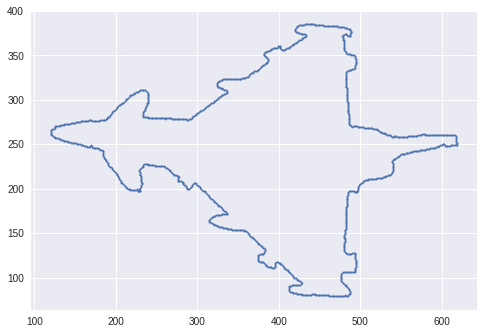

4

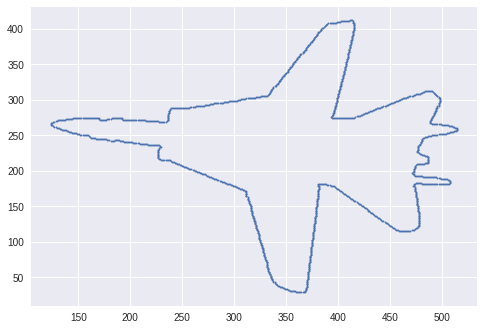

5

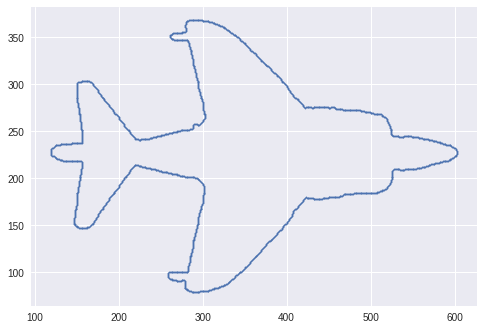

1

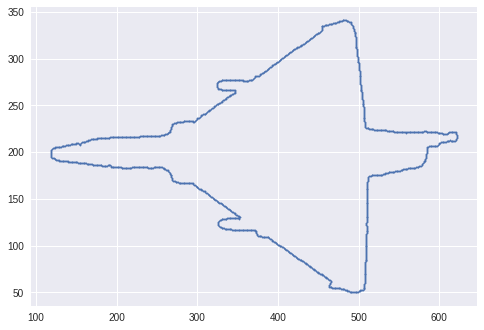

5

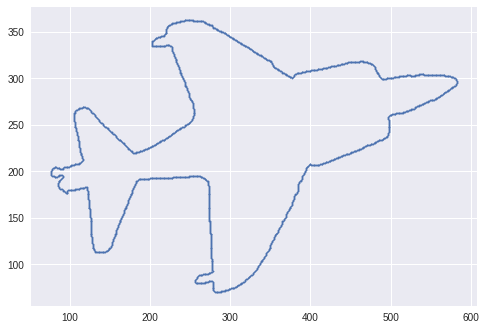

'Starting to compute hu moments... '

100%|██████████| 210/210 [00:03<00:00, 52.73it/s]


'KNeighborsClassifier'

array([0.66666667, 0.61904762, 0.64285714, 0.5952381 , 0.64285714])

'Accuracy: 0.63 (+/- 0.05)'

'SVC'

array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714])

'Accuracy: 0.14 (+/- 0.00)'

'GaussianNB'

array([0.9047619 , 0.97619048, 0.97619048, 0.9047619 , 0.92857143])

'Accuracy: 0.94 (+/- 0.06)'

#### Using dataset 1

'Number of features per class'

Counter({1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20})

##### Samples

1

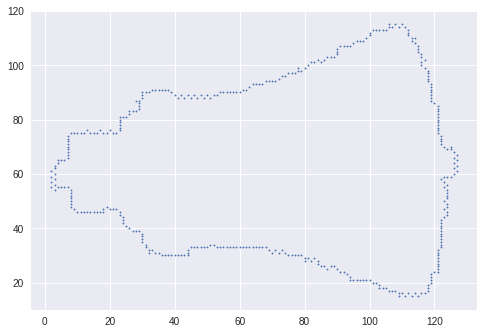

4

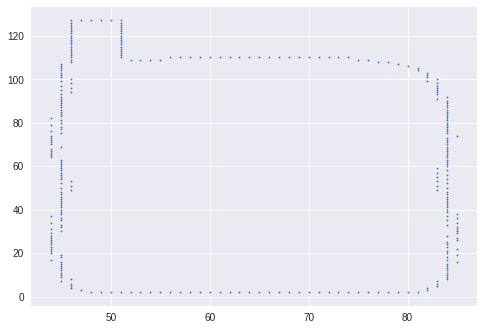

5

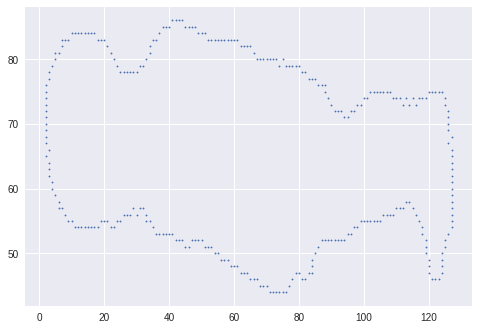

5

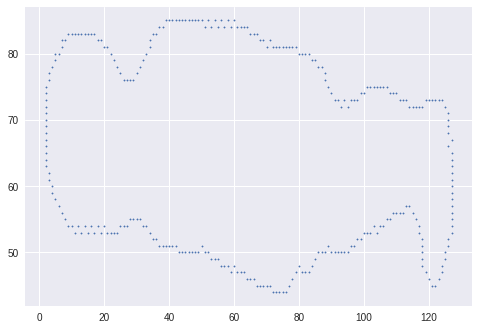

2

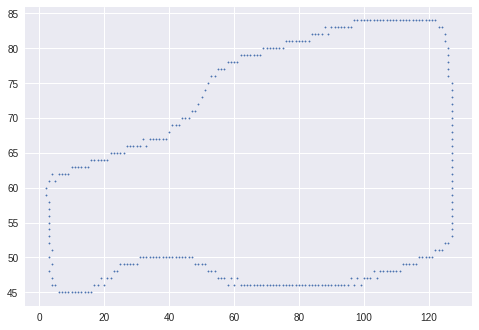

'Starting to compute hu moments... '

100%|██████████| 120/120 [00:00<00:00, 261.70it/s]


'KNeighborsClassifier'

array([1.        , 0.95833333, 1.        , 1.        , 1.        ])

'Accuracy: 0.99 (+/- 0.03)'

'SVC'

array([0.91666667, 0.875     , 0.95833333, 0.95833333, 0.875     ])

'Accuracy: 0.92 (+/- 0.07)'

'GaussianNB'

array([0.95833333, 0.95833333, 1.        , 1.        , 0.83333333])

'Accuracy: 0.95 (+/- 0.12)'

#### Using dataset 2

'Number of features per class'

Counter({1: 30, 2: 30, 3: 30, 4: 30})

##### Samples

4

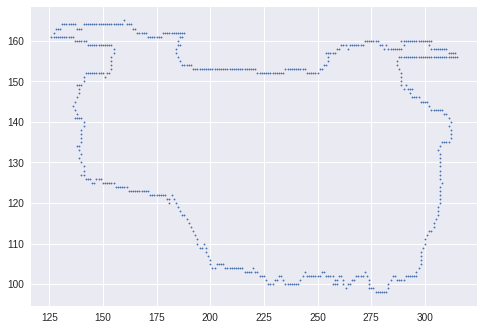

4

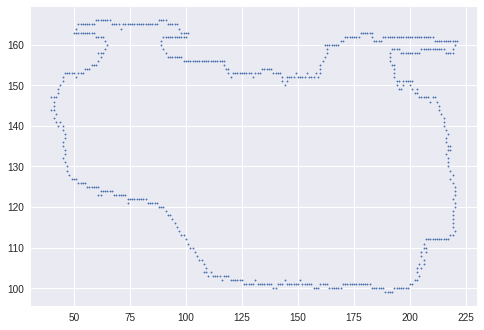

2

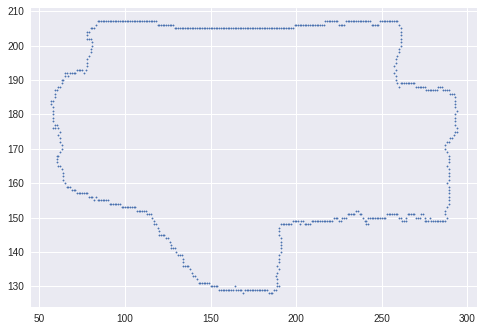

2

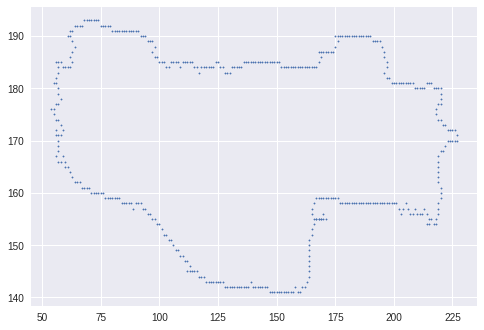

4

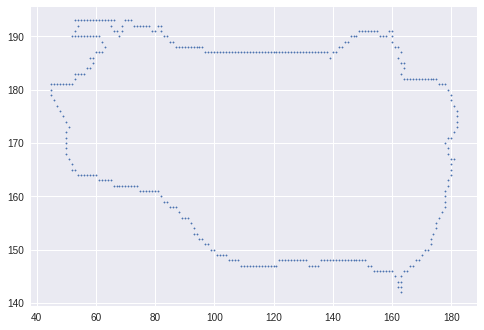

'Starting to compute hu moments... '

100%|██████████| 120/120 [00:00<00:00, 178.44it/s]


'KNeighborsClassifier'

array([0.54166667, 0.54166667, 0.625     , 0.70833333, 0.5       ])

'Accuracy: 0.58 (+/- 0.15)'

'SVC'

array([0.5       , 0.5       , 0.54166667, 0.5       , 0.54166667])

'Accuracy: 0.52 (+/- 0.04)'

'GaussianNB'

array([0.5       , 0.70833333, 0.66666667, 0.41666667, 0.16666667])

'Accuracy: 0.49 (+/- 0.39)'

#### Using dataset 3

'Number of features per class'

Counter({1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20})

##### Samples

2

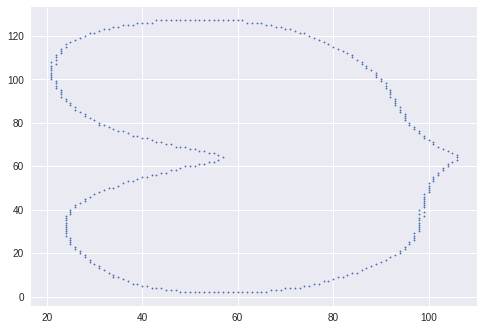

6

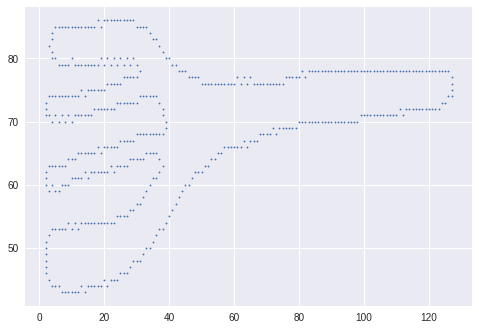

3

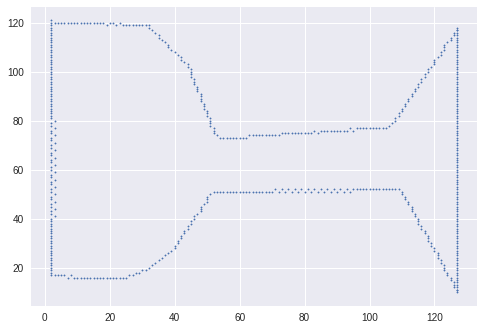

7

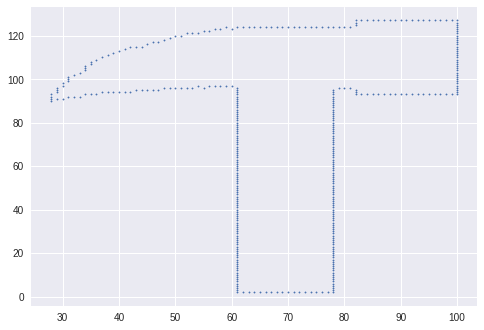

7

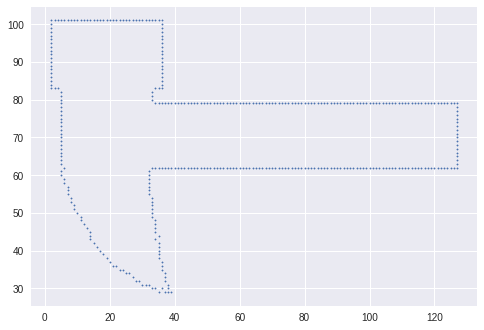

'Starting to compute hu moments... '

100%|██████████| 140/140 [00:00<00:00, 201.87it/s]


'KNeighborsClassifier'

array([0.82142857, 0.82142857, 0.78571429, 0.89285714, 0.85714286])

'Accuracy: 0.84 (+/- 0.07)'

'SVC'

array([0.5       , 0.64285714, 0.42857143, 0.60714286, 0.39285714])

'Accuracy: 0.51 (+/- 0.19)'

'GaussianNB'

array([0.96428571, 0.96428571, 0.96428571, 1.        , 1.        ])

'Accuracy: 0.98 (+/- 0.03)'

In [352]:
classifiers = [KNeighborsClassifier(n_neighbors=5), SVC(gamma='auto'), GaussianNB()]
clf_names = ['KNeighborsClassifier', 'SVC', 'GaussianNB']
for i in range(4):
    classify_using_dataset(i, classifiers)

(2, 2)


/home/ang3lino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


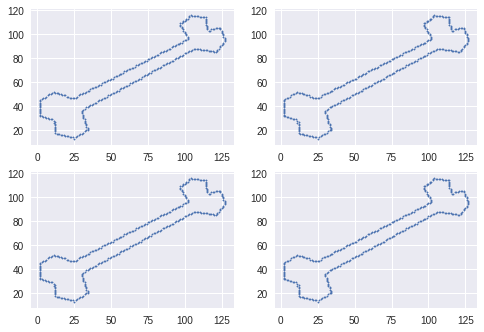

In [359]:
x_i = X[0]
u, v = col_j(x_i, 0), col_j(x_i, 1)

fig, axes = plt.subplots(2, 2)
axes[0,0].scatter(u, v, s=2)
axes[0,1].scatter(u, v, s=2)
axes[1,0].scatter(u, v, s=2)
axes[1,1].scatter(u, v, s=2)
print(axes.shape)
fig.show()